In [2]:
import tensorflow as tf
import scipy
import matplotlib.pyplot as plt
import os
from keras.layers import Conv2D,Rescaling,RandomFlip,RandomRotation,Dense,Flatten,MaxPooling2D,InputLayer,Dropout,RandomZoom,RandomBrightness,RandomTranslation,LeakyReLU,Conv2DTranspose,BatchNormalization,Reshape,Embedding,Concatenate,Input,ReLU
from keras.losses import SparseCategoricalCrossentropy,BinaryCrossentropy
from keras.utils import plot_model
from keras import Sequential
from keras.optimizers import Adam,SGD,RMSprop
from pathlib import Path
import numpy as np
import copy
from random import randint
import keras
import time
import math

tf.config.list_physical_devices(), tf.__version__

([PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')],
 '2.16.2')

In [4]:
rescale = lambda x,y: ((x/255.0) ,y) # rescale image from 0...255 to 0...1
preprocess = lambda x,y: ((x-0.5)/0.5 ,y) # normalize images from 0...1 to -1...1
rotate = RandomRotation(factor=0.4,name="rotate") # rotates image
flip = RandomFlip(mode="horizontal_and_vertical",name="flip") # flips images
zoom = RandomZoom(height_factor=(-0.2, -0.2), name="zoom") # zooms into image
display_model = lambda x,y: plot_model(x,show_shapes=True,show_layer_names=True,to_file=f'{y}.png',show_layer_activations=True) # helper function to plot model

In [5]:
no_of_class = 102 # total class
IMG_SIZE = (150,150) # desired image size
BATCH = 12 # batch-size (use only batch_size which is multiple of 3/6/12/24)

train = tf.keras.utils.image_dataset_from_directory('../102_flowers_dataset/train/',image_size=IMG_SIZE,shuffle=True,batch_size=BATCH)

# applying preprocessing (rescale,preprocess)
train = train.map(rescale) 
train = train.map(preprocess)
train = train.map(lambda x,y: (rotate(x),y))
train = train.map(lambda x,y: (flip(x),y))

Found 6552 files belonging to 102 classes.


2024-10-07 17:35:19.105079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


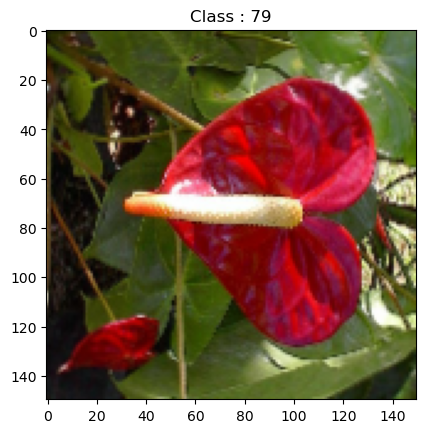

In [6]:
# sampling a image

for i,j in train.take(1):
    plt.imshow(i[0].numpy()*0.5+0.5)
    plt.title(f'Class : {j[0].numpy()}')

In [7]:
# base downsampling/convo layers

class discriminator_class():
    def __init__(self) -> None:
        self.count = 0
        
    def __call__(self,filters:int,strides:int,input:keras.Layer) -> keras.Layer:
        self.count += 1
        
        x = Conv2D(filters=filters, kernel_size=(3,3), strides=strides, padding='same', name=f'Convo_{self.count}')(input)
        x = LeakyReLU(name=f'Leaky_{self.count}')(x)
        x = BatchNormalization(name=f'Batch_Norm_{self.count}')(x)
        x = Dropout(0.3,name=f'Dropout_{self.count}')(x)
        return x
    
# base dense layer builder
class dense_class():
    def __init__(self) -> None:
        self.count = 1
    
    def __call__(self, filters:list,input: keras.Layer) -> keras.Layer:
        
        x = input
        
        for i in filters:
            x = Dense(i,name=f'Dense_{self.count}')(x)
            x = ReLU(name=f'Relu_{self.count}')(x)
            self.count += 1
        
        return x


# make the discriminator(Input-> img,label : Output -> class,real/fake)
def make_discriminator_ac(img: tuple[int],no_of_class:int) -> keras.Model:
    label_input = Input(shape=(1,),name='label_input')
    
    l = Embedding(no_of_class,256,name='label_embedding')(label_input)
    l = Dense(np.prod(img)*1,name='label_dense')(l)
    l = Reshape((img[0], img[1],1),name='label_Reshape')(l)
    
    img_input = Input(shape=(img[0],img[1],3),name='image_input')
    y = rotate(img_input)
    y = zoom(y)
    y = flip(y)
    
    merge = Concatenate(name='concatenate')([y,l])
    
    discriminator_block = discriminator_class()
    dense_block = dense_class()
    
    x = discriminator_block(32,2,merge)
    x = discriminator_block(32,2,x)    
    x = discriminator_block(64,2,x)
    x = discriminator_block(64,2,x)
    x = discriminator_block(128,2,x)
    x = discriminator_block(256,2,x)
    x = discriminator_block(512,2,x)
    x = discriminator_block(512,1,x)
    
    x = Flatten(name='flatten')(x)
    
    
    label_based = dense_block([384,256,128],x)
    label_based = Dense(no_of_class+1,activation='softmax',name='label_predict')(label_based) # softmax to condense the array into probability
    
    real_based = dense_block([384,256,128,64],x)
    real_based = Dense(1, activation='sigmoid',name='real_predict')(real_based) # sigmoid for real/fake classification
    
    discriminator = tf.keras.Model([img_input,label_input],[label_based,real_based],name='AC_Discriminator')
    
    return discriminator

make_discriminator_ac(IMG_SIZE,no_of_class).summary()

Model: "AC_Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rotate              │ (None, 150, 150,  │          0 │ image_input[0][0] │
│ (RandomRotation)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_embedding     │ (None, 1, 256)    │     26,112 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zoom (RandomZoom)   │ (None, 150, 150,  │          0 │ rotate[0][0]      │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_dense (Dense) │ (None, 1, 22500)  │  5,782,500 │ label_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flip (RandomFlip)   │ (None, 150, 150,  │          0 │ zoom[0][0]        │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_Reshape       │ (None, 150, 150,  │          0 │ label_dense[0][0] │
│ (Reshape)           │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 150, 150,  │          0 │ flip[0][0],       │
│ (Concatenate)       │ 4)                │            │ label_Reshape[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Convo_1 (Conv2D)    │ (None, 75, 75,    │      1,184 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Leaky_1 (LeakyReLU) │ (None, 75, 75,    │          0 │ Convo_1[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Batch_Norm_1        │ (None, 75, 75,    │        128 │ Leaky_1[0][0]     │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_1 (Dropout) │ (None, 75, 75,    │          0 │ Batch_Norm_1[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Convo_2 (Conv2D)    │ (None, 38, 38,    │      9,248 │ Dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Leaky_2 (LeakyReLU) │ (None, 38, 38,    │          0 │ Convo_2[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Batch_Norm_2        │ (None, 38, 38,    │        128 │ Leaky_2[0][0]     │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_2 (Dropout) │ (None, 38, 38,    │          0 │ Batch_Norm_2[0][… │
│                     │ 32)               │            │                 

 Total params: 11,648,012 (44.43 MB)

 Trainable params: 11,644,812 (44.42 MB)

 Non-trainable params: 3,200 (12.50 KB)

In [8]:
display_model(make_discriminator_ac(IMG_SIZE,no_of_class),'../model_arch/ac_disc')

In [9]:
latent_dim = np.array([5,5,256]) # the latent space we will derive images from
noise_shape = 256 # shape of noise vector/array/tensor
# IMG TRANSFORM => 150 - 5, 5, 3, 2
# base upsampling/convo Transpose layers
class upsample_class():
    def __init__(self) -> None:
        self.count = 0
    
    def __call__(self,filters:int,strides:int,kernel:int,input:keras.Layer) -> keras.Layer:
        self.count += 1
        
        x = Conv2DTranspose(filters,(kernel,kernel),strides=strides,padding='same', name=f'conv_{self.count}',use_bias=False)(input)
        x = ReLU(name=f'relu_{self.count}')(x)
        x = BatchNormalization(name=f'norm_{self.count}')(x)
        x = Dropout(0.1,name=f'drop_{self.count}')(x)
        return x
    

# make generator (Input -> noise,label : Output -> img)
def make_generator_ac(no_of_class:int,noise_shape:tuple[int],latent_dim:tuple[int]) -> keras.Model:
    
    label_input = Input(shape=(1,),name='label_input')
    l = Embedding(no_of_class,512,name='label_embedding')(label_input)
    l = Dense(np.cumprod(latent_dim)[-2]*128,name='label_dense')(l)
    l = Reshape(np.append(latent_dim[:-1],[128]),name='label_Reshape')(l)
    
    noise_input = Input(shape=(noise_shape,),name='noise_input')
    n = Dense(np.prod(latent_dim),name='noise_dense')(noise_input)
    n = Reshape(latent_dim,name='noise_reshape')(n)
    
    merge = Concatenate(name='concatenate')([n,l])
    upsample_block = upsample_class()
    
    x = upsample_block(filters=512,strides=1,kernel=5,input=merge)
    x = upsample_block(filters=256,strides=2,kernel=3,input=x)

    x = upsample_block(filters=256,strides=1,kernel=6,input=x)
    x = upsample_block(filters=128,strides=3,kernel=3,input=x)
    
    x = upsample_block(filters=128,strides=1,kernel=7,input=x)
    x = upsample_block(filters=64,strides=5,kernel=3,input=x)
    
    x = upsample_block(filters=64,strides=1,kernel=5,input=x)

    x = upsample_block(filters=32,strides=1,kernel=3,input=x)
    
    
    x = Conv2DTranspose(3,(3,3),strides=1,padding='same', name='final',activation='tanh')(x) # tanh to normalize values between -1 and 1
    
    generator = tf.keras.Model([noise_input,label_input],x,name='AC_Generator')
    
    return generator

make_generator_ac(no_of_class,noise_shape,latent_dim).summary()

Model: "AC_Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ label_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noise_input         │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_embedding     │ (None, 1, 512)    │     52,224 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noise_dense (Dense) │ (None, 6400)      │  1,644,800 │ noise_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_dense (Dense) │ (None, 1, 3200)   │  1,641,600 │ label_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noise_reshape       │ (None, 5, 5, 256) │          0 │ noise_dense[0][0] │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_Reshape       │ (None, 5, 5, 128) │          0 │ label_dense[0][0] │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 5, 5, 384) │          0 │ noise_reshape[0]… │
│ (Concatenate)       │                   │            │ label_Reshape[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1              │ (None, 5, 5, 512) │  4,915,200 │ concatenate[0][0] │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu_1 (ReLU)       │ (None, 5, 5, 512) │          0 │ conv_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_1              │ (None, 5, 5, 512) │      2,048 │ relu_1[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_1 (Dropout)    │ (None, 5, 5, 512) │          0 │ norm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2              │ (None, 10, 10,    │  1,179,648 │ drop_1[0][0]      │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu_2 (ReLU)       │ (None, 10, 10,    │          0 │ conv_2[0][0]      │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_2              │ (None, 10, 10,    │      1,024 │ relu_2[0][0]      │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_2 (Dropout)    │ (None, 10, 10,    │          0 │ norm_2[0][0]      │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_3              │ (None, 10, 10,    │  2,359,296 │ drop_2[0][0]      │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu_3 (ReLU)       │ (None, 10, 10,    │          0 │ conv_3[0][0]      │
│                     │ 256)              │            │                 

 Total params: 13,091,683 (49.94 MB)

 Trainable params: 13,088,803 (49.93 MB)

 Non-trainable params: 2,880 (11.25 KB)

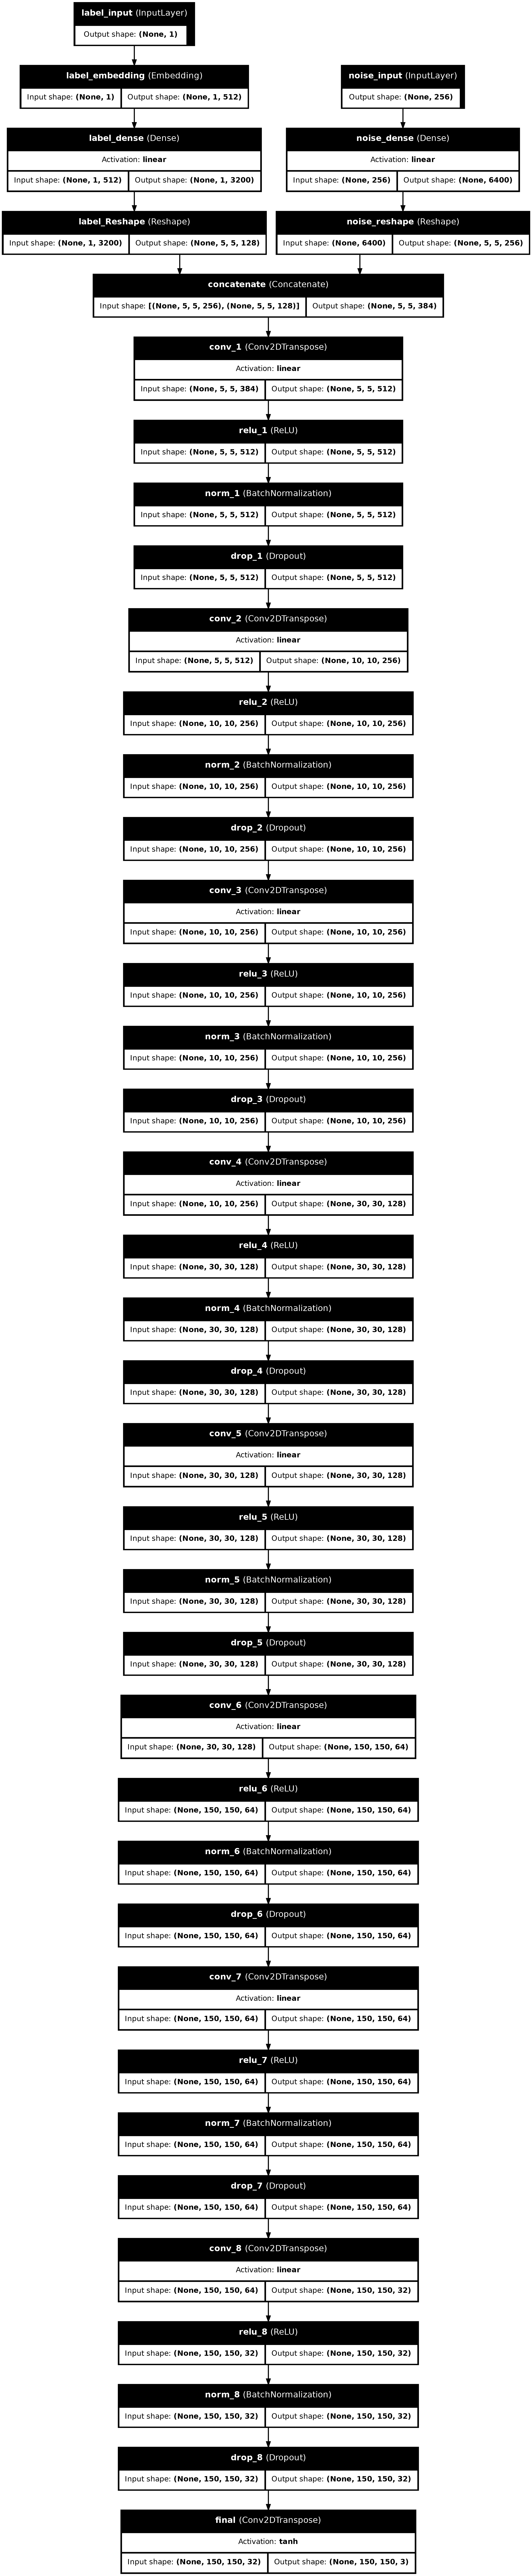

In [10]:
display_model(make_generator_ac(no_of_class,noise_shape,latent_dim),'../model_arch/ac_gen')

In [13]:
# AC GAN Class
class AC_GAN(tf.keras.Model):
    def __init__(self, latent_dim:np.ndarray,noise_shape:int,img_shape:tuple[int]) -> None:
        super(AC_GAN,self).__init__()
        self.latent_shape = latent_dim
        self.noise_shape = noise_shape
        self.img = img_shape
        self.generator = make_generator_ac(no_of_class,self.noise_shape,self.latent_shape)
        self.discriminator = make_discriminator_ac(self.img,no_of_class)
        self.gen_real_loss = tf.keras.metrics.Mean(name="generator_real_loss")
        self.dis_real_loss = tf.keras.metrics.Mean(name="discriminator_real_loss")
        self.dis_class_loss = tf.keras.metrics.Mean(name="discriminator_class_loss")
        self.dis_accuracy = tf.keras.metrics.Accuracy(name='discriminator_accuracy')
        
    @property
    def metrics(self):
        return [self.gen_real_loss,self.dis_real_loss,self.dis_class_loss,self.dis_accuracy]
    
    def compile(self,gen_opt,dis_opt,real_loss,class_loss):
        super(AC_GAN,self).compile()
        self.gen_opt = gen_opt
        self.dis_opt = dis_opt
        self.real_loss_func = real_loss
        self.class_loss_func = class_loss
    
    # when class object is called as a function, returns a image from a noise and labrl
    def call(self,noise:tf.Tensor,label:int) -> tf.Tensor:
        gen_img = self.generator([noise,label],training=False)
        return gen_img
    
    # main train step used in fit() function
    @tf.function
    def train_step(self, image:tf.Tensor) -> None:
        img, label = image
        label = tf.expand_dims(label,axis=-1)
        noise = tf.random.normal([BATCH, self.noise_shape]) # random noise we will use
        
        with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
            # Generator Output: img
            generated = self.generator([noise,label],training=True)

            # Discriminator Output: [class,real/fake]
            predicted_class, real_class = self.discriminator([img,label],training=True) # passing actual images
            generated_predicted_class, generated_real_class = self.discriminator([generated,label],training=True) # passing generated images
            
            dis_loss_real = self.real_loss_func(generated_real_class, False) + self.real_loss_func(real_class, True) # discriminator loss regarding classification (real/fake) of generated images and actual images 
            dis_loss_class = self.class_loss_func(label, predicted_class)  #+ self.class_loss_func(no_of_class*tf.ones(BATCH,dtype=tf.int32), generated_predicted_class) # discriminator loss regarding classification (class) of generated images and actual images
            gen_loss_real = self.real_loss_func(generated_real_class, True)  # generator loss regarding classification (real/fake) of generated images 
            
            gen_total_loss = gen_loss_real
            dis_total_loss = dis_loss_class + dis_loss_real
            
        gradients_d = disc_tape.gradient(dis_total_loss, self.discriminator.trainable_variables)
        gradients_g = gen_tape.gradient(gen_total_loss, self.generator.trainable_variables)
        
        self.dis_opt.apply_gradients(zip(gradients_d, self.discriminator.trainable_variables))
        self.gen_opt.apply_gradients(zip(gradients_g, self.generator.trainable_variables))
        
        self.gen_real_loss.update_state(gen_loss_real)
        self.dis_real_loss.update_state(dis_loss_real)
        self.dis_class_loss.update_state(dis_loss_class)
        self.dis_accuracy.update_state(label,tf.argmax(predicted_class,axis=1))
                
        return {m.name: m.result() for m in self.metrics}
    
    def save_model(self):        
        try:
            self.discriminator.save('../saved_weights/acgan/dis.keras')
            print('Saved the discriminator')
        except:
            print('Error saving the discriminator')
            
        try:
            self.generator.save('../saved_weights/acgan/gen.keras')
            print('Saved the generator')
        except:
            print('Error saving the generator')
            
    def load_model(self):        
        try:
            self.discriminator.load_weights('../saved_weights/acgan/dis.keras')
            print('Loaded the discriminator')
            
        except:
            print('Error loading the discriminator')
            
        try:
            self.generator.load_weights('../saved_weights/acgan/gen.keras')
            print('Loaded the generator')
            
        except:
            print('Error loading the generator')

In [14]:
acgan = AC_GAN(latent_dim,noise_shape,IMG_SIZE)

dis_opt = Adam(learning_rate=0.0001)
gen_opt = Adam(learning_rate=0.0005)

binary_entropy = BinaryCrossentropy()
cross_entropy = SparseCategoricalCrossentropy()

# loss func for binary classification (real/fake) 
def real_loss(real:tf.Tensor,isReal:bool) -> tf.Tensor:
    return binary_entropy(tf.ones_like(real)*0.9, real) if isReal else binary_entropy(tf.zeros_like(real)+0.1, real)

# loss func for multi-class classification (label) 
def class_loss(generated:tf.Tensor,real:tf.Tensor) -> tf.Tensor:
    return cross_entropy(generated,real)

In [15]:
acgan.load_model() # loaded presaved weights from saved_weights/acgan

Loaded the discriminator
Loaded the generator


In [16]:
acgan.compile(gen_opt,dis_opt,real_loss,class_loss) # adding optimizers and loss func

In [101]:
history = acgan.fit(train,epochs=10) # training model. Remember: (a) Generator and Discrimnator losses should be oscillating, (b) If one is very large and other small model ain't learning, (c) Avoid Model Collapse (both loss becoming zero)

Epoch 1/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 125s 228ms/step - discriminator_accuracy: 0.9993 - discriminator_class_loss: 0.0042 - discriminator_real_loss: 1.3117 - generator_real_loss: 0.8306
Epoch 2/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 125s 228ms/step - discriminator_accuracy: 0.9995 - discriminator_class_loss: 0.0037 - discriminator_real_loss: 1.2945 - generator_real_loss: 0.8243
Epoch 3/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 125s 229ms/step - discriminator_accuracy: 0.9952 - discriminator_class_loss: 0.0238 - discriminator_real_loss: 1.3095 - generator_real_loss: 0.8080
Epoch 4/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 125s 229ms/step - discriminator_accuracy: 0.9972 - discriminator_class_loss: 0.0104 - discriminator_real_loss: 1.3137 - generator_real_loss: 0.8104
Epoch 5/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 125s 228ms/step - discriminator_accuracy: 0.9980 - discriminator_class_loss: 0.0107 - discriminator_real_loss: 1.3234 - generator_real_loss: 0.8090
Epoch 6/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 905s 2s/step - discr

In [102]:
acgan.save_model() # save weights

Saved the discriminator
Saved the generator


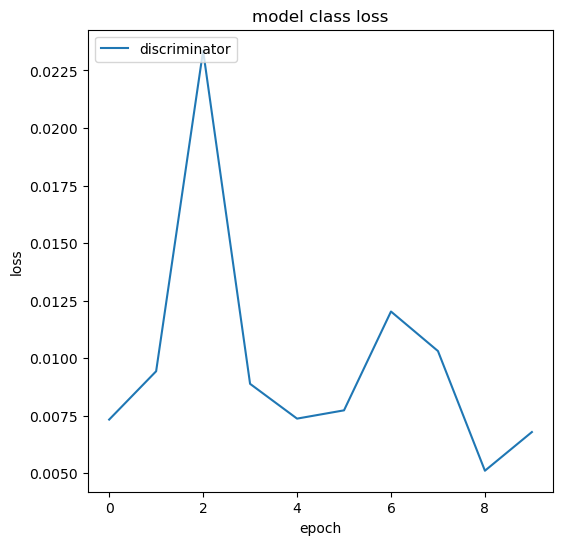

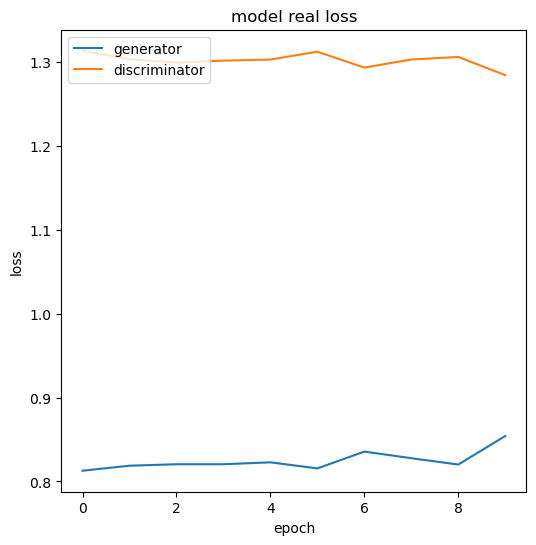

In [103]:
# plotting multi-class classification loss
plt.figure(figsize=(6,6))
plt.plot(history.history['discriminator_class_loss'])
plt.title('model class loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['discriminator'], loc='upper left')
plt.show()

# plotting binary classification loss
plt.figure(figsize=(6,6))
plt.plot(history.history['generator_real_loss'])
plt.plot(history.history['discriminator_real_loss'])
plt.title('model real loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['generator', 'discriminator'], loc='upper left')
plt.show()

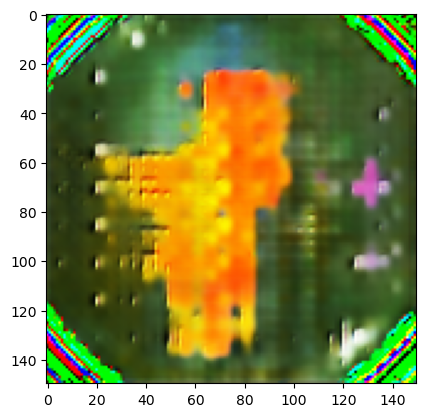

In [106]:
noise=  tf.random.normal([1, noise_shape]) # random noise
label = tf.Variable([4]) # label

pred = acgan(noise,label) # classing class
plt.imshow((pred[0, :, :, :]+1)/2.0) # image resuly
